# AB Test Walkthrough
---
### Summary: 
A/B Testing is a ubiquitous topic in the field of data science, and is commonly observed in business contexts where product design is approached from a data driven perspective. 

A quintessential example of an A/B test would be testing for the effectiveness of a new drug. In such a pharmaceutical setting, the term 'randomized control experiment' may be more familiar. 

In a nutshell, such an A/B testing experiment entails:
1. Recruiting a sample population of willing participants for testing the new drug
2. Randomly administer a placebo to half of the sample population (the 'control' group) and the new drug to the other half (the 'treatment' group)
3. Wait and see what happens
4. Statistically analyze the results to draw conclusions on the effectiveness of the drug

Experiments like this are applicable outisde of the pharmaceutical setting, in product design and ecommerce advertising. For example, an App developer may employ an A/B test to determine which of two User Interface designs is more appealing to users.

### Challenges:

Although the big idea behind the A/B test is quite simple, executing such an experiment with a high degree of veracity can be incredibly technically challenging:
* Technical details such as the determining the right sample size can be a challenge
* Ensuring independence across observations can be tough, when users all coexist in the same environment (i.e. spill over effect of administering the treatment)
* Primacy/Novelty effects may interfere with the treatment effect


### Objective: 
In this notebook we walk through the technical steps of conducting an A/B test.

In [143]:
from IPython.display import YouTubeVideo
YouTubeVideo('j5DoJV5S2Ao&t=895s')

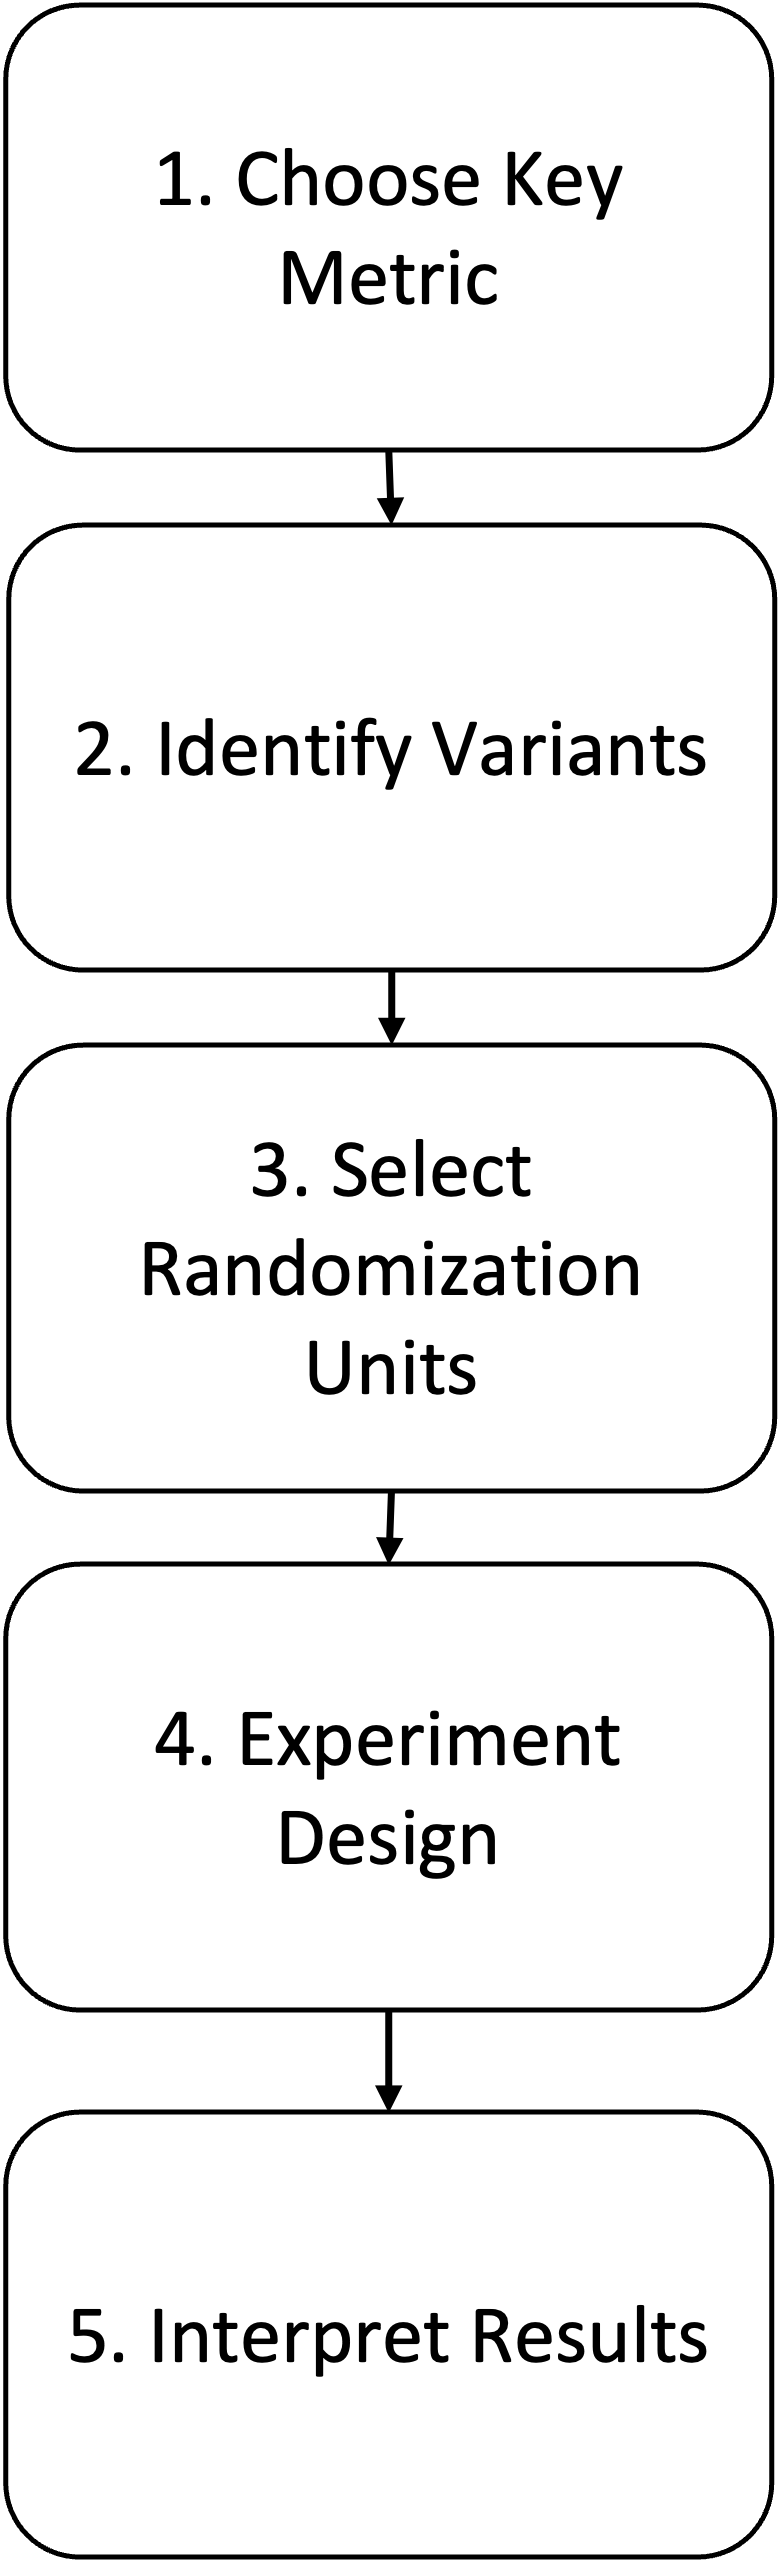

In [54]:
from IPython.display import Image
Image(filename="ab_testing_process_flow.png", width=200, height = 600)

#{"tags": ["hide-input"]}

### General Process:
The general process flow of conducting an A/B experiemnt is depicted in the figure above. Many of these steps requires input from business stakeholders, and decisions must be made from multiple angles in addition to the statistical perspective:
1. Choosing the Key Metric
    * This should be a measurable metric, which is tied to the overall business objective (i.e. increase revenue)
    * A typical metric is the conversion rate 
2. Identify Variants
    * In an A/B test we have two variants (i.e. the control and treatment) 
    * The only difference between the two variants should be the treatment effect
3. Randomization Unit
    * Identify the lowest level unit at which the key metric is going to be measured (i.e. unique users)
4. Experiment Design
    * This step involves setting the parameters for the experiment (the significance level, power, and MDE)
    * A ramp-up deployment strategy should be considered to control for primacy/novelty effects
5. Interpret Results
    * Once we have the results of the test, we will make an assessment on whether to roll out the new feature or not based on the statistical and practical significance of the outcomes

###  Assumptions:
* Independence across observations

Big Questions:
> "How many samples do we need to collect for our experiment to reach a specific significance and power level?"

---
# Zoom in On Step 4: Selecting the Experiment Parameters for the A/B Test

Let's say we want to detect the difference in the means between Sample A and Sample B, with the following parameters:
* Power ($\beta$) = 90%
* Significance ($\alpha$) = 0.05%
* Minimum Detectable Effect ($\Delta d$) = 0.125

And we wish to test the following two-sided experiment, with a Minimum Detectable Effect of 0.125 and a Power of 90% at a 5% significance level:
$$
\begin{align}
H_0:& \mu_A = \mu_B \\
H_1:& \mu_A \ne \mu_B
\end{align}
$$

Now our question turns to "What sample size do I need?"

---
## Definition of Significance Level and Power 

The **significance level** is the probability of a Type I error (i.e. the probability of rejecting the null hypothesis when it is actually true)

The **power** is $(1-\beta)$ where $\beta$ is the probability of a Type II error
    * i.e. the probability of correctly rejecting the null hypothesis when the alternative is true

$$
\begin{align}
\text{significance level} &= P(\text{Reject $H_0$} | H_0 = True) \\
\beta &= P(\text{Fail to Reject $H_0$} | H_1 = True) \\
\text{Power} &= P(\text{Reject $H_0$} | H_1 = True)
\end{align}
$$

In the context of the confusion matrix: 


It is more intuitive to understand the significance and power visually, after selecting the test statistic for the two-sample hypothesis test.

### Test Statistic (Welch's T-test): 

$$
\begin{align}
t = \dfrac{\bar{X}_A - \bar{X}_B}{\sqrt{ \frac{s^2_A}{N_A} + \frac{s^2_B}{N_B}}}
\end{align}
$$

The Welch's t-test is used when we are comparing sample means from two populations which may not have the same variance and/or sample size. 


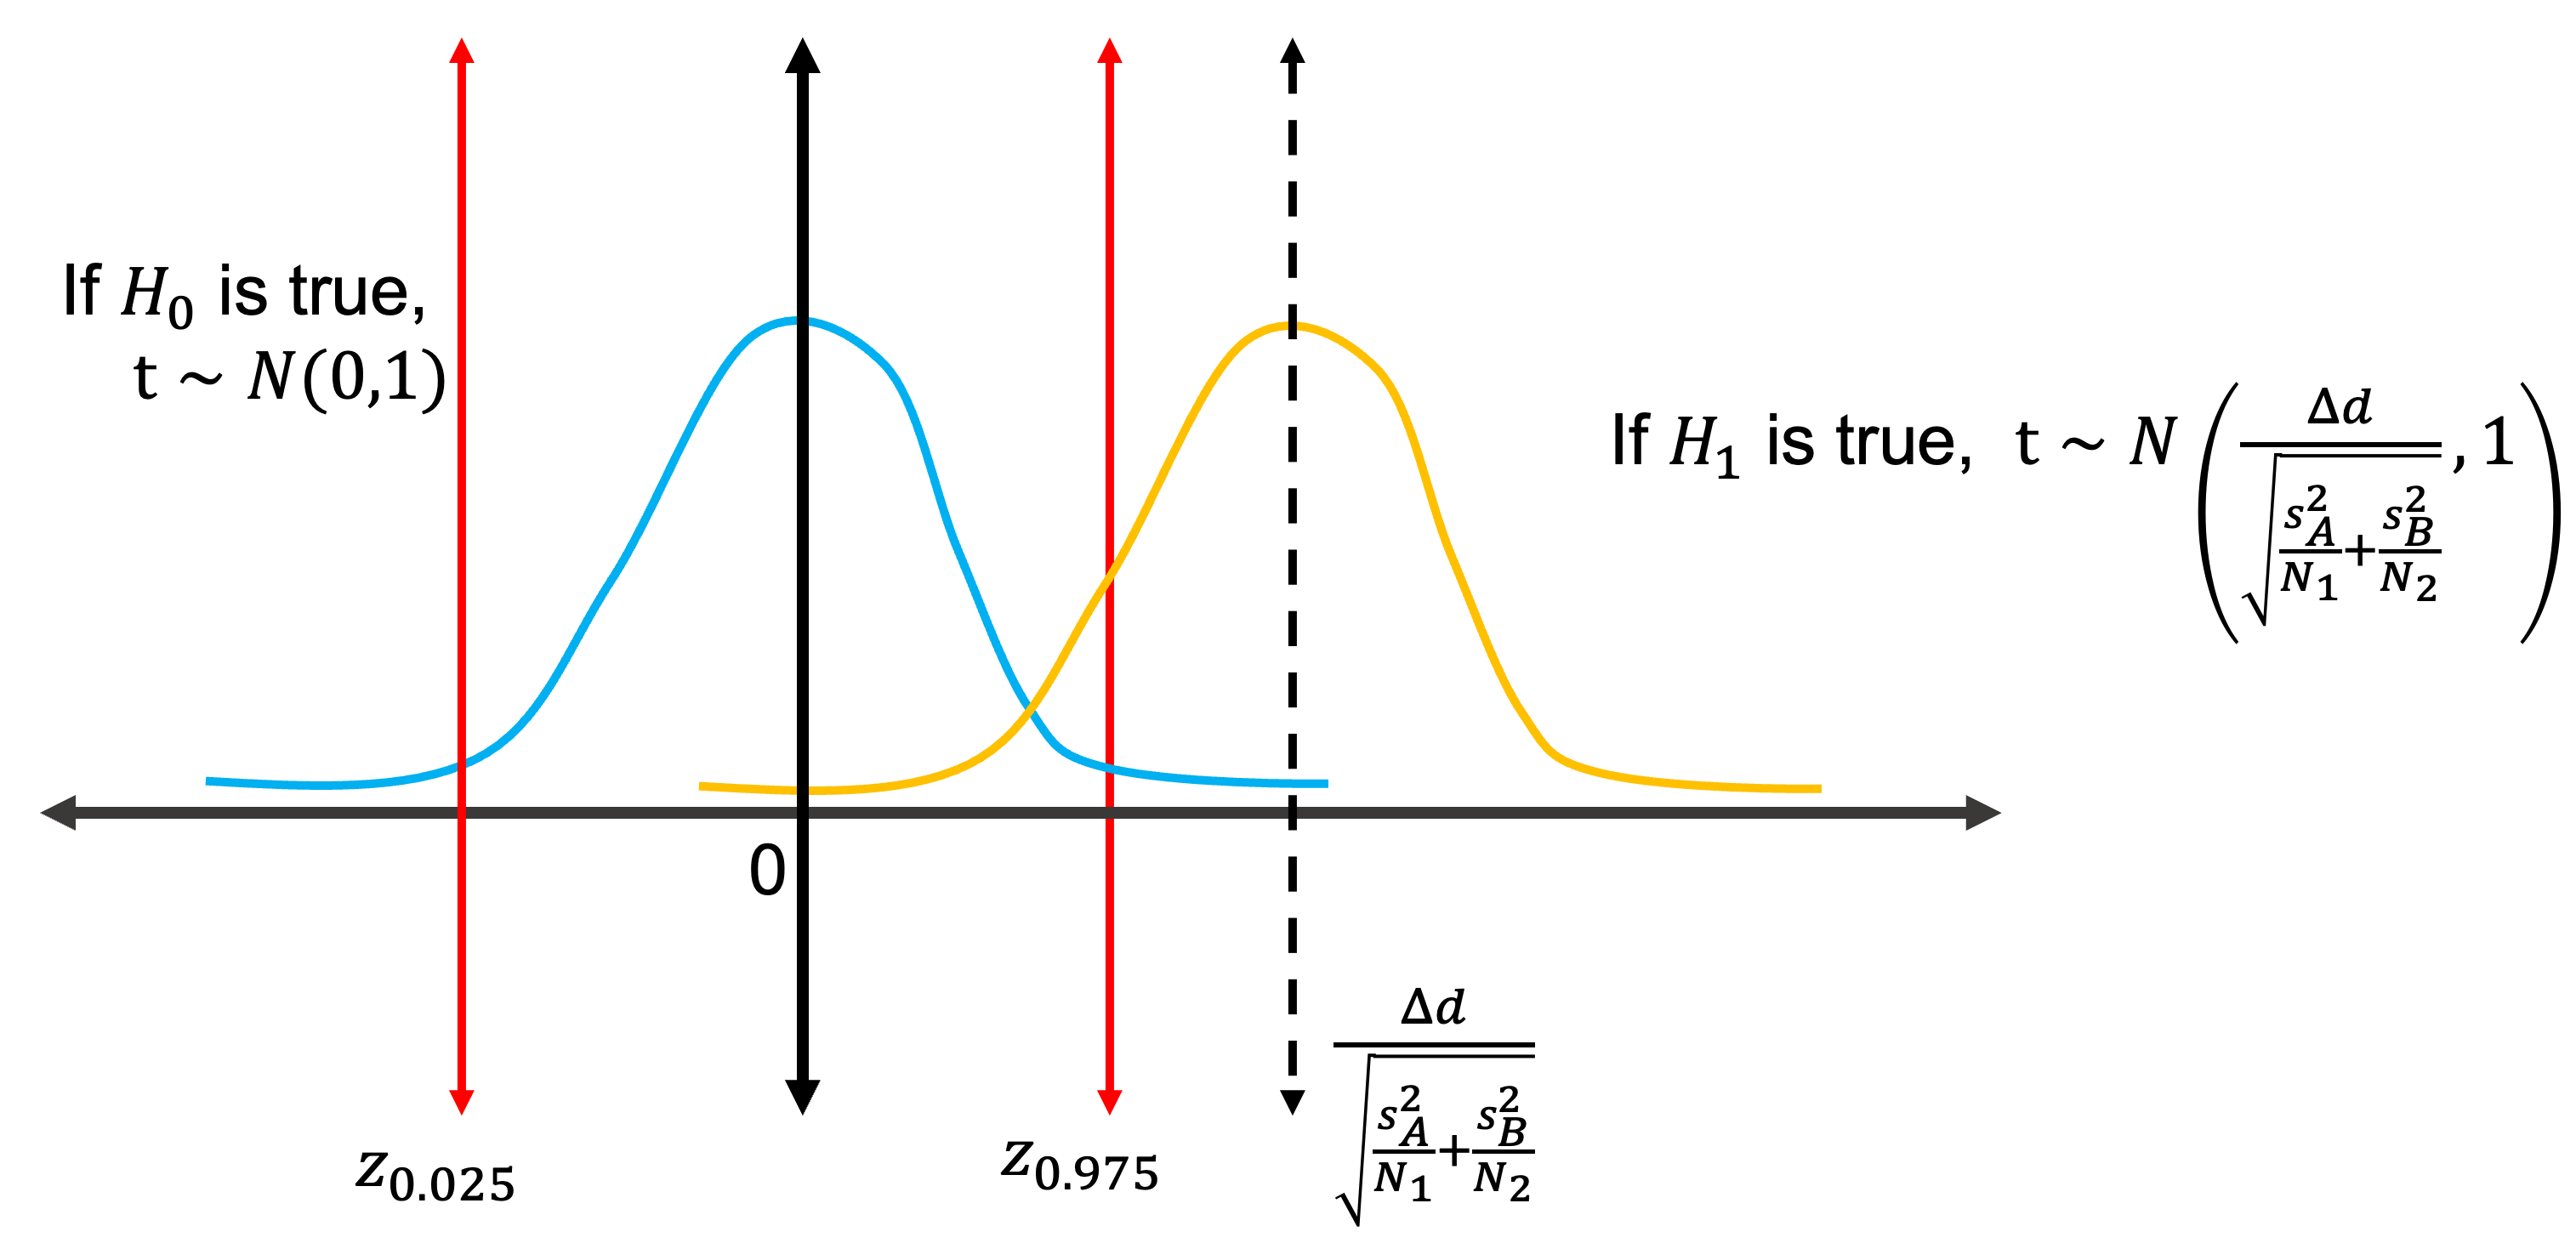

In [59]:
from IPython.display import Image
Image(filename="ab_testing_figure1.png", width=800, height = 400)

### Type I Error
Under our null hypothesis $H_0: \mu_A=\mu_B$, if we assumed that the null hypothesis is true, then we would expect that the test statistic follows a standard normal distribution (depicted with the blue bell curve in the figure). 

$$
\begin{align}
t \sim N(0, 1)
\end{align}
$$

Under this assumption in our two-sided experiment, we would conclude that a difference in means is not significant if the test statistic falls within the 95% confidence interval range $ t \in (z_{0.025}, z_{0.975})$, which in the figure above is indicated with the two red vertical lines. 

$$
\begin{align}
z_{0.025} &= \Phi^{1}(0.025) \approx -1.96 \\
z_{0.975} &= \Phi^{-1}(0.975) \approx 1.96
\end{align}
$$

In [154]:
from scipy.stats import norm

""" Getting the Critical Values for a Two-Sided Hypothesis with 5% Significance Level """
critical_level_lower = norm.ppf(0.025).round(decimals=6) # z_0.025
critical_level_upper = norm.ppf(0.975).round(decimals=6) # z_0.975

print(f"Critical Level Lower: {critical_level_lower} \n Critical Level Upper: {critical_level_upper}")

Critical Level Lower: -1.959964 
 Critical Level Upper: 1.959964


Alternatively, if the test statistic falls outside of the red vertical lines, then we would reject the null hypothesis - even if it is actually true. 

The probability of rejecting the null hypothesis when the hypothesis is actually true is called the Type I error probability, or the *significance level*. 

$$
\begin{align}
P(\text{Type I Error}) &= P(\text{Reject }H_0 | H_0 = True) \\
&= \text{Area Underneath Blue Curve $\cap$ Area Outside Critical Values} \\
&= \alpha 
\end{align}
$$

We have full control of the Type I Error probability when conducting our experiment because it is determined by our choice of the significance level parameter.

### Type II Error

However, if the the null hypothesis ($H_0: \mu_A = \mu_B$) is false, and the alternative hypothesis is true ($H_1: \mu_A \ne \mu_B$), then we can have a situation where the mean of the two populations are different by an amount $\Delta d$.

\begin{align}
 \mu_A = \mu_B + \Delta d
\end{align}

In which case we would expect that the test statistic is not centered at zero (e.g. it may be off to the right like the orange curve in the figure above).

$$
\begin{align}
t \sim N \left(\dfrac{\Delta d}{\sqrt{ \dfrac{s^2_A}{N_A} + \dfrac{s^2_B}{N_B}}}, 1 \right)
\end{align}
$$

The Type II error probability is the probability that the test statistics falls within the critical thresholds, assuming that $H_1 = True$:

$$
\begin{align}
P(\text{Type II Error}) &= P(\text{Fail to Reject }H_0 | H_1 = True) \\
&= \text{Area Underneath Orange Curve $\cap$ Area Between Critical Values} \\
&= \beta
\end{align}
$$

Since we would not know where the orange curve in the figure above actually is when conducting a real experiment (i.e. we do not know the true population means of sample A and sample B before doing the experiment), the Type II error probability is not known beforehand. 

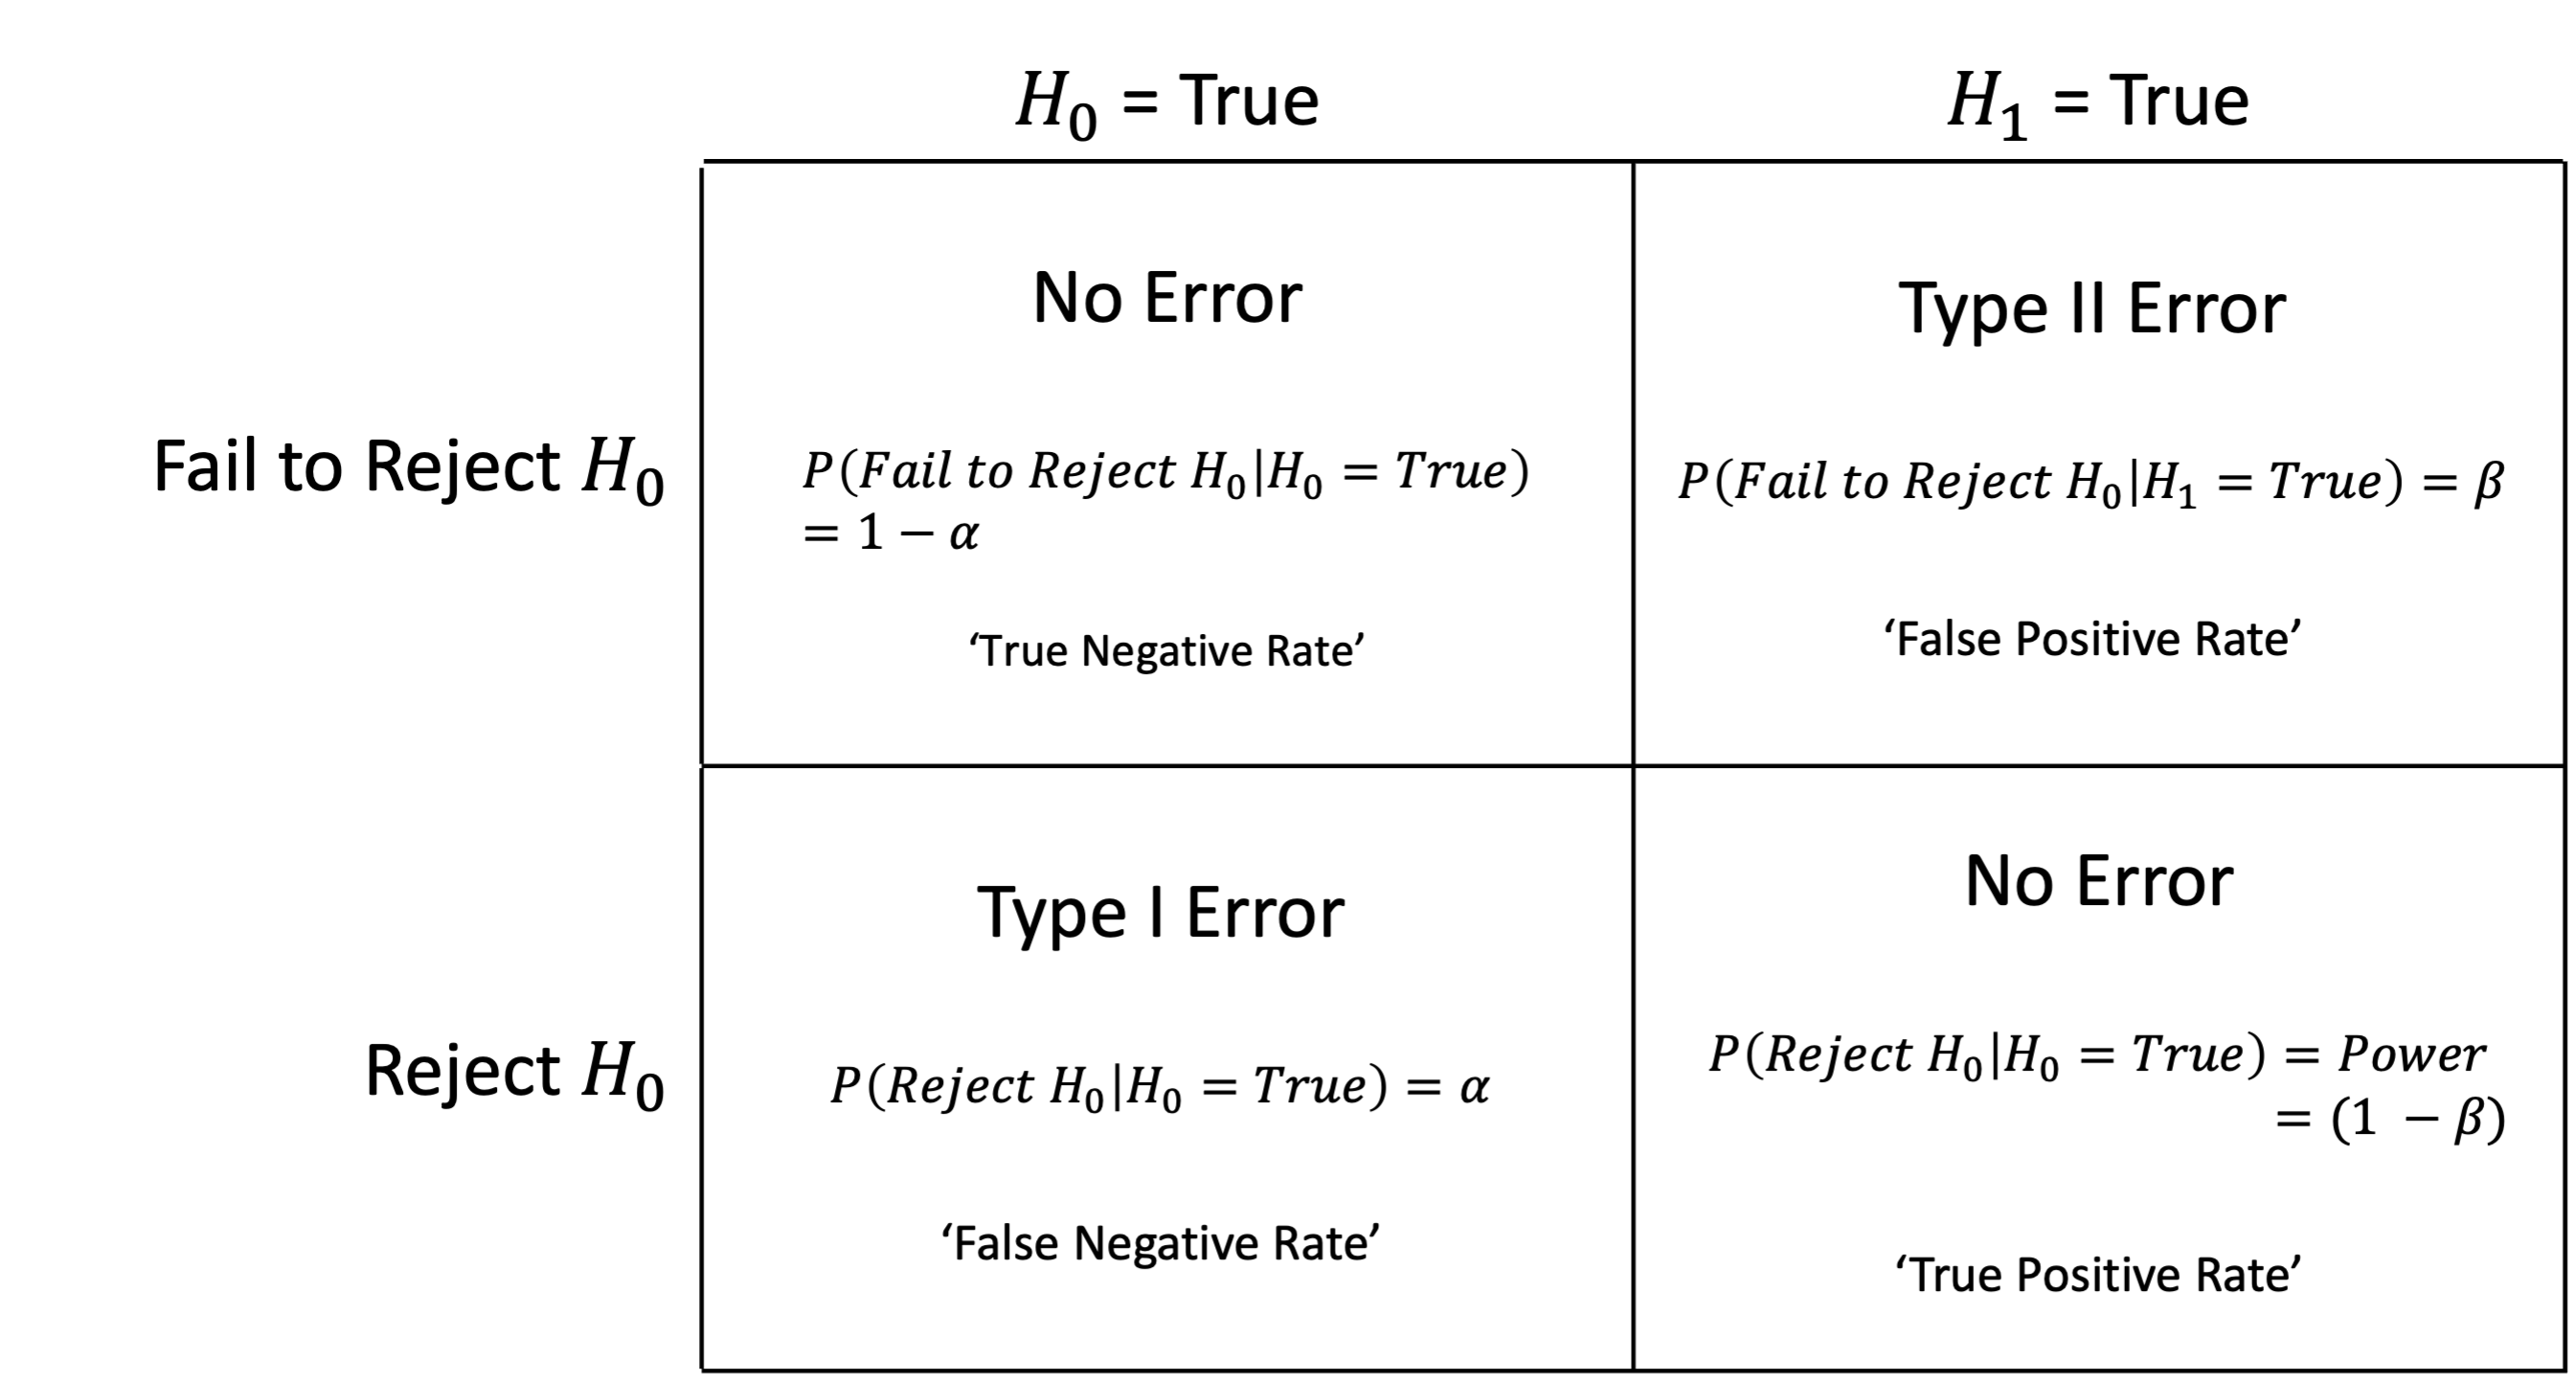

In [155]:
from IPython.display import Image
Image(filename="confusion_matrix.png", width=800, height = 400)

---
## Monte Carlo Simulation 
Let us now pretend that we have a situation in which 

### Test Samples:
We start our example with A/B samples drawn from two different Gamma distributions:

$$
\begin{align}
X_A &\sim Gamma(\kappa=0.5, \theta=1) \\
X_B &\sim Gamma(\kappa=0.5, \theta=0.75)
\end{align}
$$

We know that the mean of a Gamma distribution is the product of the shape and scale parameters ($\kappa, \theta$), so we can retrieve the true means:

$$
\begin{align}
\mu_A &= 0.5 \\
\mu_B &= 0.375
\end{align}
$$

The difference between the two means is therefore: 
$$ \mu_A - \mu_B = 0.125 $$

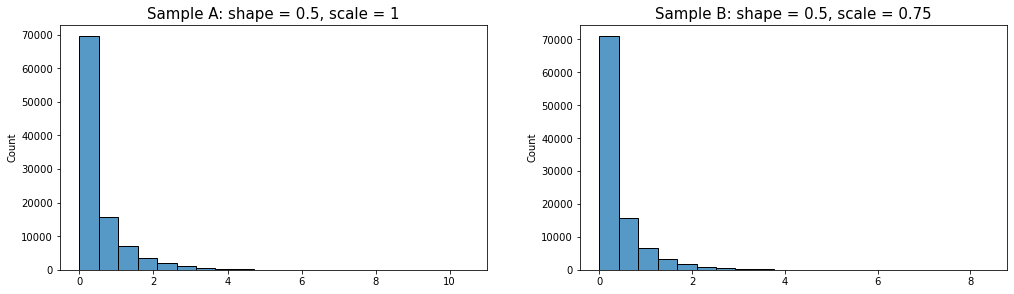

In [104]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sample_A = np.random.gamma(0.5, 1, 100000)
sample_B = np.random.gamma(0.5, 0.75, 100000)

mu_A = 0.5
mu_B = 0.375

fig, axes = plt.subplots(1, 2, figsize = (15,5))
sns.histplot(sample_A, bins = 20, ax = axes[0])
sns.histplot(sample_B, bins = 20, ax = axes[1])

axes[0].set_title("Sample A: shape = 0.5, scale = 1", fontsize = 15)
axes[1].set_title("Sample B: shape = 0.5, scale = 0.75", fontsize = 15)
plt.tight_layout(pad = 4)

In [85]:
"""Function for calculating the test statistic for Welch's t-test for a given sample size N"""
def test_statistic(N):
    x_A = np.random.choice(sample_A, size = N, replace=False)
    x_B = np.random.choice(sample_B, size = N, replace=False)

    meanA = np.average(x_A)
    meanB = np.average(x_B)

    sample_sd_A = np.std(x_A, ddof=1)
    sample_sd_B = np.std(x_B, ddof=1)

    test_statistic = (meanA - meanB) / np.sqrt( (sample_sd_A**2)/N + (sample_sd_B**2)/N)

    return(np.round(test_statistic, decimals=6))


Monte Carlo simulation to retrieve 20,000 realizations of the test statistic when sample sizes are {50, 100, 500, 1000}:

In [91]:
t_vec_50 = [test_statistic(x) for x in np.repeat(50, 20000)]
t_vec_100 = [test_statistic(x) for x in np.repeat(100, 20000)]
t_vec_500 = [test_statistic(x) for x in np.repeat(500, 20000)]
t_vec_1000 = [test_statistic(x) for x in np.repeat(1000, 20000)]

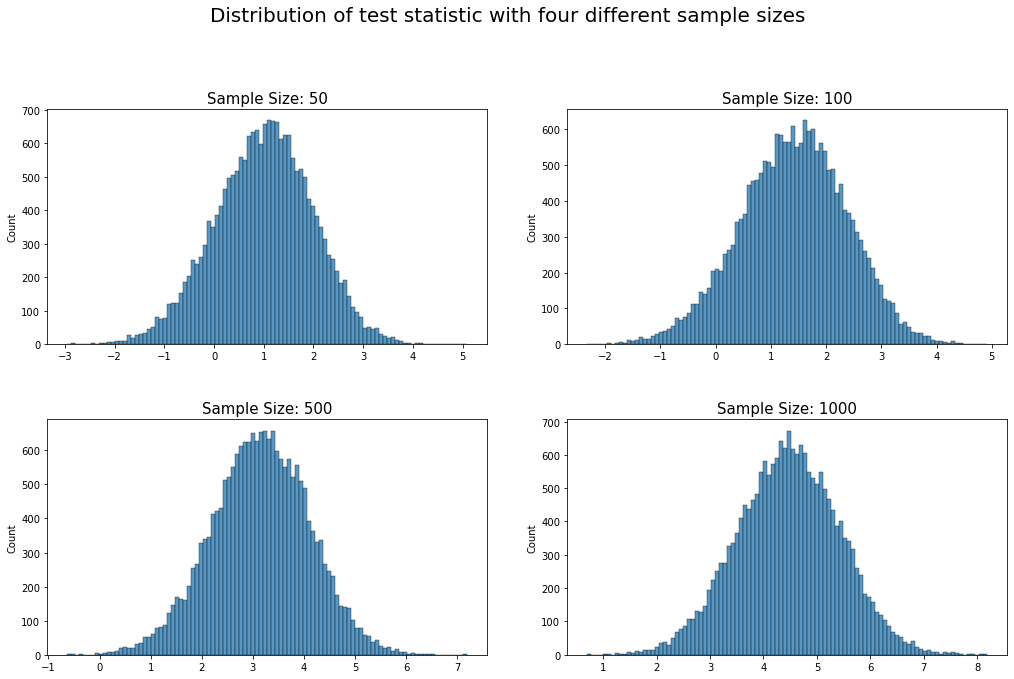

In [99]:
fig, axes = plt.subplots(2, 2, figsize = (15,10))
sns.histplot(t_vec_50, bins = 100, ax = axes[0,0])
sns.histplot(t_vec_100, bins = 100, ax = axes[0,1])
sns.histplot(t_vec_500, bins = 100, ax = axes[1,0])
sns.histplot(t_vec_1000, bins = 100, ax = axes[1,1])

plt.suptitle("Distribution of test statistic with four different sample sizes", fontsize = 20)
axes[0,0].set_title("Sample Size: 50", fontsize = 15)
axes[0,1].set_title("Sample Size: 100", fontsize = 15)
axes[1,0].set_title("Sample Size: 500", fontsize = 15)
axes[1,1].set_title("Sample Size: 1000", fontsize = 15)
plt.tight_layout(pad = 4)

Below we can see more clearly that the mean of the distributions is moving to the right as sample size increases.

<AxesSubplot:xlabel='value', ylabel='Count'>

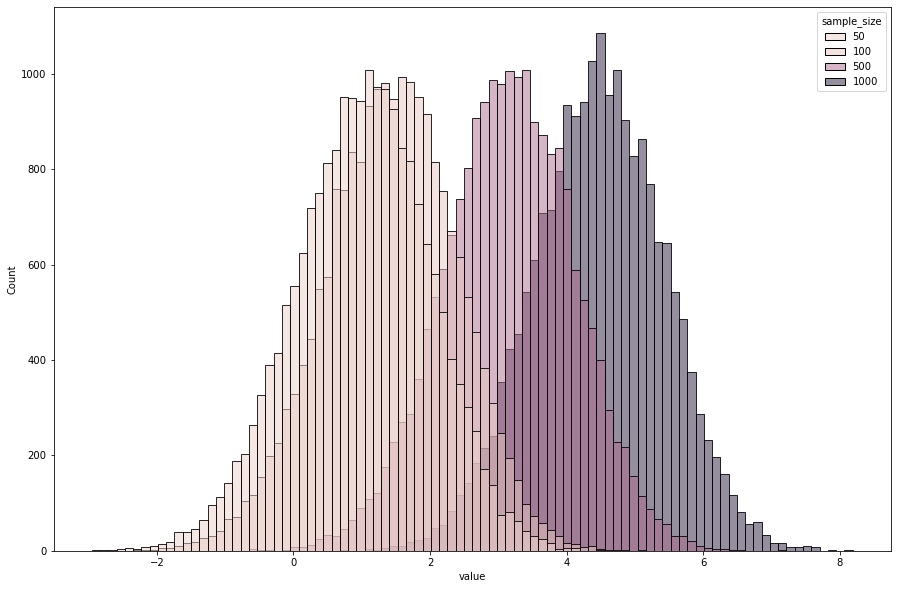

In [166]:
df = pd.concat(axis=0, ignore_index=True, objs= [
    pd.DataFrame.from_dict({'value': t_vec_50, 'sample_size': 50}),
    pd.DataFrame.from_dict({'value': t_vec_100, 'sample_size': 100}),
    pd.DataFrame.from_dict({'value': t_vec_500, 'sample_size': 500}),
    pd.DataFrame.from_dict({'value': t_vec_1000, 'sample_size': 1000})
])

fig, axes = plt.subplots(figsize = (15,10))
sns.histplot(data=df, x='value', hue='sample_size', ax=axes)

Our test statistic for the four different sample size choices follows a normal distribution, as expected. 

However, as $N$ increases, the test statistic is centered further and further away from zero, which is the value that we would expect if $H_0$ were true because it is the mean of the standard normal distribution $N(0,1)$.
* The smallest sample size ($N = 50$) is centered just right of 0
* The next sample size ($N = 100$) is centered further right to that one, and so forth
* The center of the normal distribution with ($N=1000$) is furthest away from 0 

In fact, we can use the formula above to calculate the theoretical means of the four distributions:

$$
\begin{align}
t \sim N \left(\dfrac{\Delta d}{\sqrt{ \dfrac{s^2_A}{N_A} + \dfrac{s^2_B}{N_B}}}, 1 \right)
\end{align}
$$

In [120]:
def theoretical_mean(N):
    deltad = 0.125
    varA = 0.5
    varB = 0.5*(0.75**2)

    denominator = np.sqrt(varA/N + varB/N)
    return np.round(deltad / denominator, decimals = 6)

In [121]:
print(f"Mean of t-vector when N = 50: {np.mean(t_vec_50).round(decimals=6)} \t Theoretical Mean: {theoretical_mean(50)}")
print(f"Mean of t-vector when N = 100: {np.mean(t_vec_100).round(decimals=6)} \t Theoretical Mean: {theoretical_mean(100)}")
print(f"Mean of t-vector when N = 500: {np.mean(t_vec_500).round(decimals=6)} \t Theoretical Mean: {theoretical_mean(500)}")
print(f"Mean of t-vector when N = 1000: {np.mean(t_vec_1000).round(decimals=6)} \t Theoretical Mean: {theoretical_mean(1000)}")

Mean of t-vector when N = 50: 1.005017 	 Theoretical Mean: 1.0
Mean of t-vector when N = 100: 1.417343 	 Theoretical Mean: 1.414214
Mean of t-vector when N = 500: 3.152502 	 Theoretical Mean: 3.162278
Mean of t-vector when N = 1000: 4.471255 	 Theoretical Mean: 4.472136


And we can see above that the values above are very close to each other, validating our understanding of the test statistic's distribution. 

The beta values can then be calculated: 

$$
\begin{align}
\beta &= P(\text{Fail to Reject $H_0$} | H_1 = True) \\
&= P(t \ge \alpha_{0.025}) + P(t \le \alpha_{0.975}) \\
&\approx P(-1.96 \le t \le 1.96)
\end{align}
$$

In [89]:
"""Function for calculating the Betas"""
def calc_betas(t_vector):
    N = len(t_vector)
    #lower_region = np.sum(t_vector < critical_level_lower)
    #upper_region = np.sum(t_vector > critical_level_upper)
    critical_region = ((t_vector >= critical_level_lower) & (t_vector <= critical_level_upper))

    beta = sum(critical_region) / N
    return beta

In [100]:
beta50 = calc_betas(t_vec_50)
beta100 = calc_betas(t_vec_100)
beta500 = calc_betas(t_vec_500)
beta1000 = calc_betas(t_vec_1000)
print(f"Beta when N = 50: {beta50} \n Beta when N = 100: {beta100} \n Beta when N = 500: {beta500} \n Beta when N = 1000: {beta1000}")

Beta when N = 50: 0.8323 
 Beta when N = 100: 0.70565 
 Beta when N = 500: 0.1061 
 Beta when N = 1000: 0.0043


[Text(0.5, 1.0, 'Power of t-test as a function of sample size'),
 Text(0.5, 0, 'Sample Size'),
 Text(0, 0.5, 'Power')]

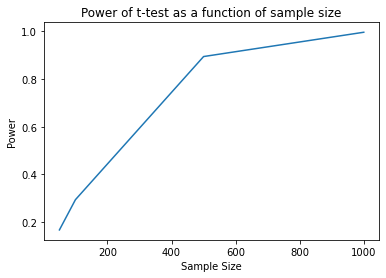

In [103]:
sns.lineplot(x=[50, 100, 500, 1000], y = [1-beta50, 1-beta100, 1-beta500, 1-beta1000]).set(title='Power of t-test as a function of sample size', xlabel = 'Sample Size', ylabel = 'Power')

## Conclusion on the Sample Size to Detect the MDE with 90% Power

Our simulation results returned that if we wanted to detect a difference in the means of Samples A and B equal to a magnitude of 0.125 with a power of 90%, we would need close to 500 samples in our experiment.

We conclude by performing the two sample t-test with a sample size of 500. 

Given that this test is 90% power, we should observe that if we ran the test 10 times consecutively, about 9 times out of 10 we would find significance, and approximately 1 times out of 10 we would fail to find significance. 

In [142]:
from scipy import stats as st

for i in range(10):
    a = np.random.choice(sample_A, size = 500)
    b = np.random.choice(sample_B, size = 500)

    t_stat, pvalue = st.ttest_ind(a, b, equal_var = False)
    print(f"P-value on trial {i+1}: {pvalue}")

P-value on trial 1: 0.0014505838219269669
P-value on trial 2: 3.4942849085401796e-06
P-value on trial 3: 0.0770582550572991
P-value on trial 4: 0.008343378334859592
P-value on trial 5: 0.04579043154148293
P-value on trial 6: 0.039604084761626565
P-value on trial 7: 0.035844298685727215
P-value on trial 8: 0.0033027547091986557
P-value on trial 9: 8.426820200373237e-06
P-value on trial 10: 0.0114784793010389


Surely enough, we failed to reject the null hypothesis on trial 3 (i.e. would have wrongly concluded that there was no difference in the means), but correctly rejected the null hypothesis 9 times out of 10. 

---
## Bayesian Approach to Hypothesis Testing